# <u>Multivariate Outlier Detection in Geochemical Datasets</u>

This notebook is intended as an open-source resource for exploring, analyzing and comparing three different methods of outlier detection in geochemical datasets in the context of mineral exploration.  
<br />
<br />
The three primary outlier detection algorithms we will use are the following: 
- Isolation Forests (IF) (Liu et al., 2008)
- Local Outlier Factor (LOF) (Breunig et al., 2000)
- Angle Based Outlier Detection (ABOD) (Shahrestani & Sanislav, 2025)
<br />
<br />

This work is driven from the findings in Antoine Caté's article on multivariate outlier detection for mineral exploration.

<br />
<br />
<u>References: </u>

*Breunig, M. M., Kriegel, H.-P., Ng, R. T., and Sander, J., 2000, LOF: Identifying Density-Based Local Outliers: ACM SIGMOD Record, v. 29, no. 2, p. 93-104.*

*Liu, F. T., Ting, K. M., and Zhou, Z.-H., 2008, Isolation Forest, 2008 Eighth IEEE International Conference on Data Mining, p. 413-422.*

*Maklin, C., 2022, Isolation Forest - Cory Maklin - Medium: Medium, https://medium.com/@corymaklin/isolation-forest-799fceacdda4.*

*Shahrestani, S., and Sanislav, I., 2025, Mapping geochemical anomalies using angle-based outlier detection approach: Journal of Geochemical Exploration, v. 269.*
<br />

---

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

import helper_functions
import outlier_detection_functions

import importlib
importlib.reload(helper_functions)
importlib.reload(outlier_detection_functions)

<module 'outlier_detection_functions' from 'c:\\Users\\TyHow\\Documents\\3. Work\\geo_datasci_tools\\geochemical_outlier_detection\\outlier_detection_functions.py'>

*For the testing of these algorithms we are going to use geochemical data from a region in southwestern Saudi Arabia. All units are converted to ppm for consistency.*

In [2]:
df = pd.read_parquet('data_files/KSA_raw_data.parquet')

In [3]:
# List of all geochemical columns to be used in the analysis - omits sample number and location columns
# List of all geochemical columns to be used in the analysis - omits sample number and location columns
feature_columns = [
    col for col in df.columns if col not in ["Sample Field Number", "Longitude", "Latitude"]
]

print(f"Selected feature columns: {feature_columns}")

Selected feature columns: ['Br', 'Cl', 'Cr', 'Hf', 'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn', 'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu', 'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I', 'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se', 'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI']


### <u>Simple EDA on the data</u>

To start off, let's do a brief investigation into broad trends or relationships in the data to get a sense of what we are working with. 

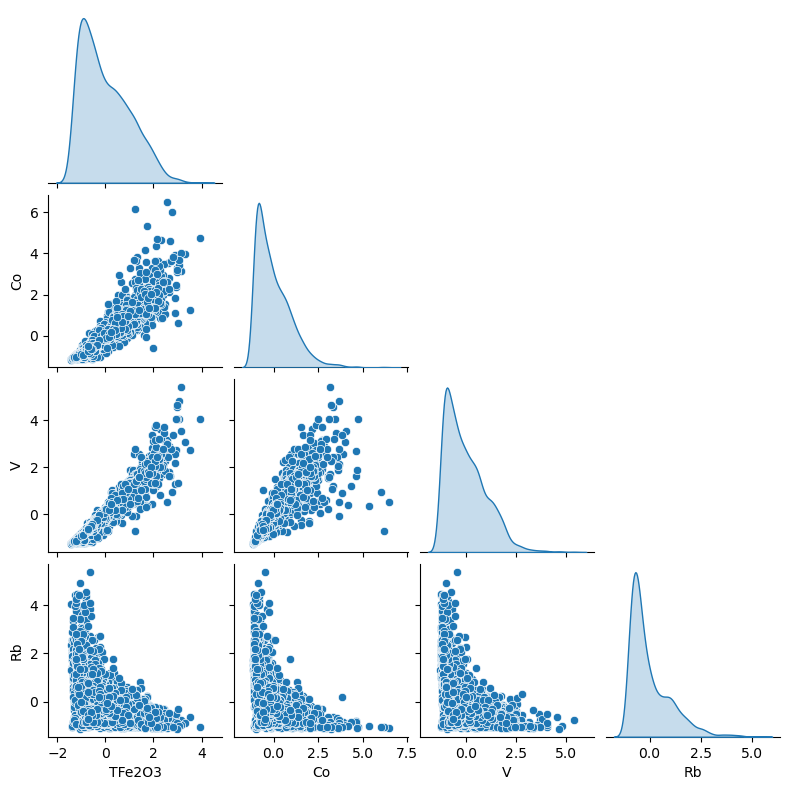

In [4]:
# Generate pairplot of select elements
elements_to_plot = ["TFe2O3", "Co", "V", "Rb"]  # Choose key elements - ideally those related to mineralization or other interesting trends
helper_functions.generate_pairplot(df, elements_to_plot, height=2)

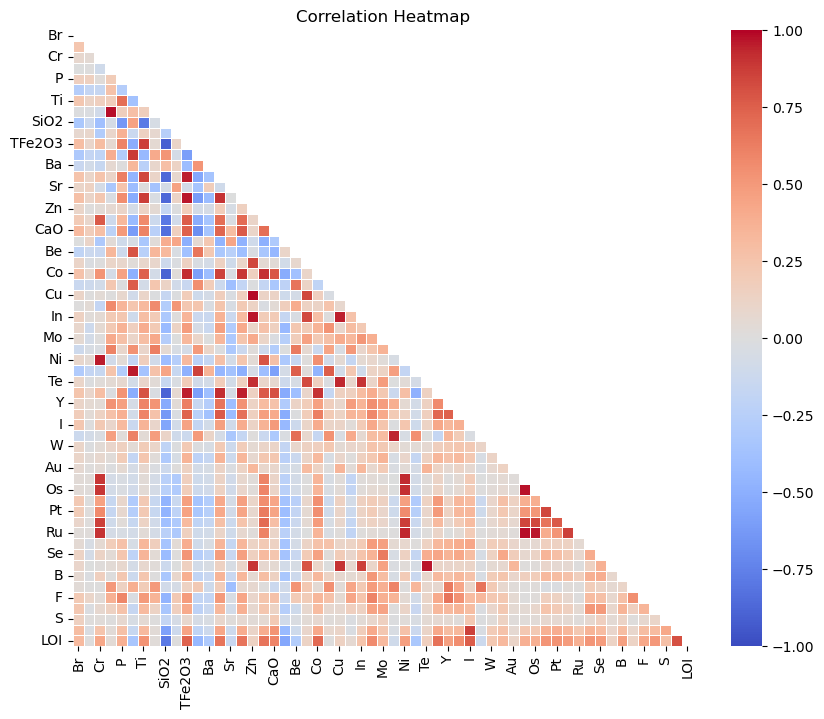

In [5]:
# Generate correlation heatmap
helper_functions.plot_correlation_heatmap(df, feature_columns, figsize=(10,8), annot=False) # Increase figsize to view all element labels

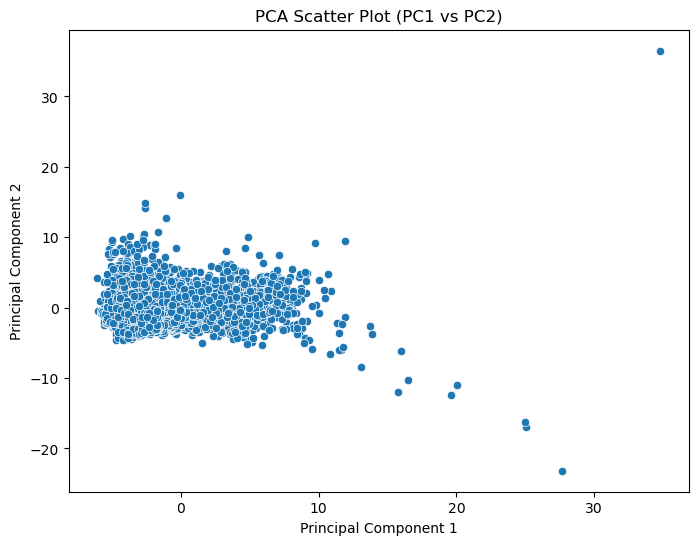

Top 5 Contributing Features to PC1: ['TFe2O3', 'Co', 'SiO2', 'Sc', 'Mn']
Top 5 Contributing Features to PC2: ['Nb', 'Sn', 'Ta', 'Hf', 'Zr']


In [6]:
# PCA
pc1_scores, top_features1, top_features2 = helper_functions.generate_pca(df, feature_columns)
print("Top 5 Contributing Features to PC1:", top_features1)
print("Top 5 Contributing Features to PC2:", top_features2)

---

## <u>Outlier Detection Methods</u>

Outliers in the binary plots below are classified using the Modified Z-Score method based on the Median Absolute Deviation (MAD). Data points with a modified Z-score greater than 3.5 are labeled as outliers (-1). This is done in place of the standard Contamination value, as it is hard to manually estimate the proportion of outliers in the datset. To modify the Z-score threshold, edit its default value at the top of the outlier_detection_functions.py file.

### <u>Isolation Forest</u>

Isolation forest is an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [7]:
IF_df = outlier_detection_functions.isolation_forest(
    df, feature_columns
)

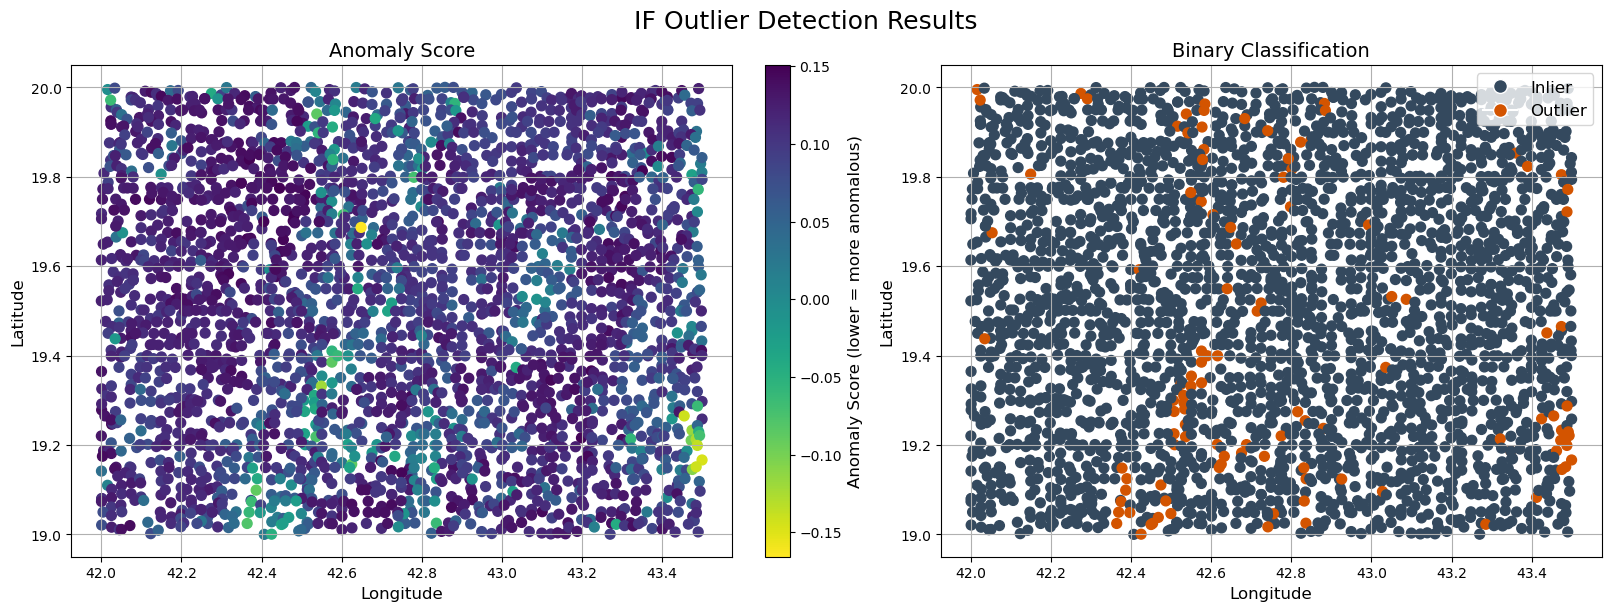

Classified 112 outliers out of 2728 samples


In [8]:
# Plotting IF results
helper_functions.plot_outlier_results(
    data=IF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
    cmap='viridis_r'
)


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a lower LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [9]:
LOF_df = outlier_detection_functions.local_outlier_factor(
    df, feature_columns, n_neighbors=50, scale_data=False
)

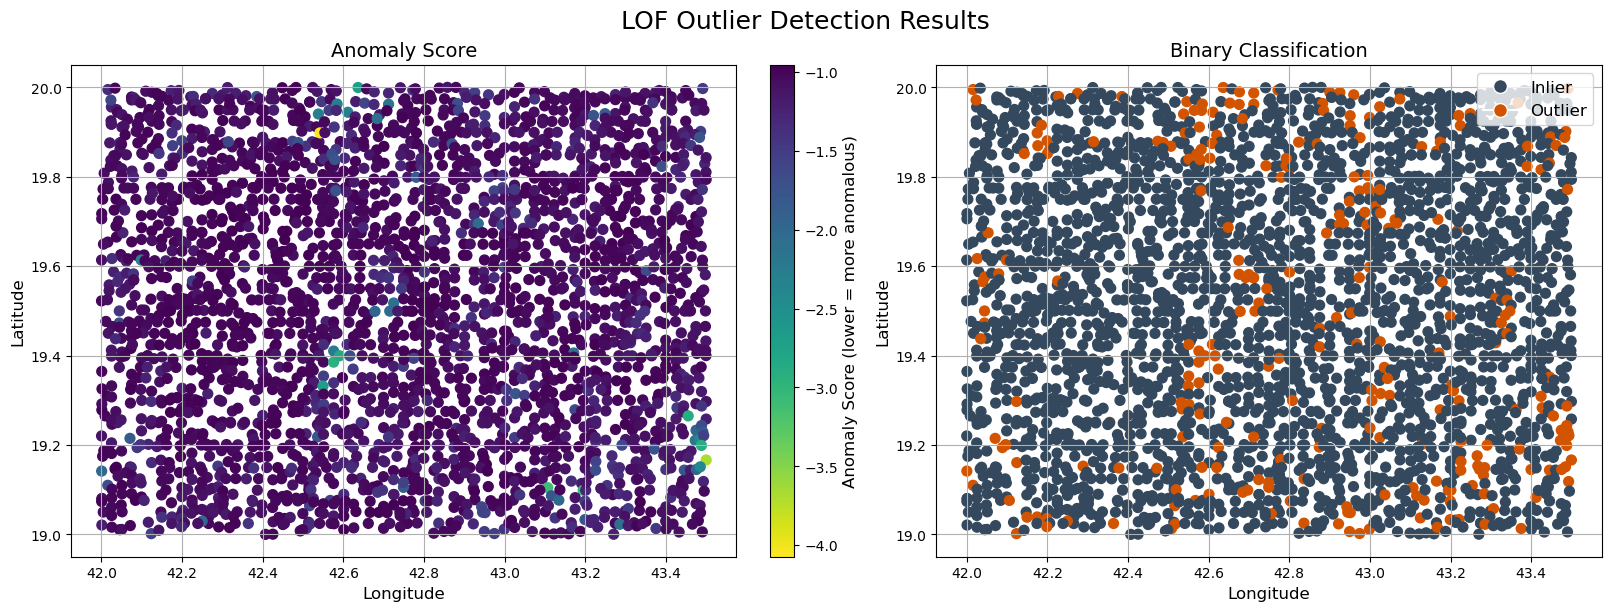

Classified 269 outliers out of 2728 samples


In [10]:
# Plotting LOF results
helper_functions.plot_outlier_results(
    data=LOF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

***Note: running the full ABOD function, with use_knn=False, takes quite a long time to process, especially for larger datasets (n>1000). It is recommended to downsample using knn if running on a large dataset, but know that the model accuracy may be impacted.*** 

In [11]:
ABOD_df = outlier_detection_functions.abod(df, feature_columns, scale_data=True, use_knn=False, k_neighbors=50)

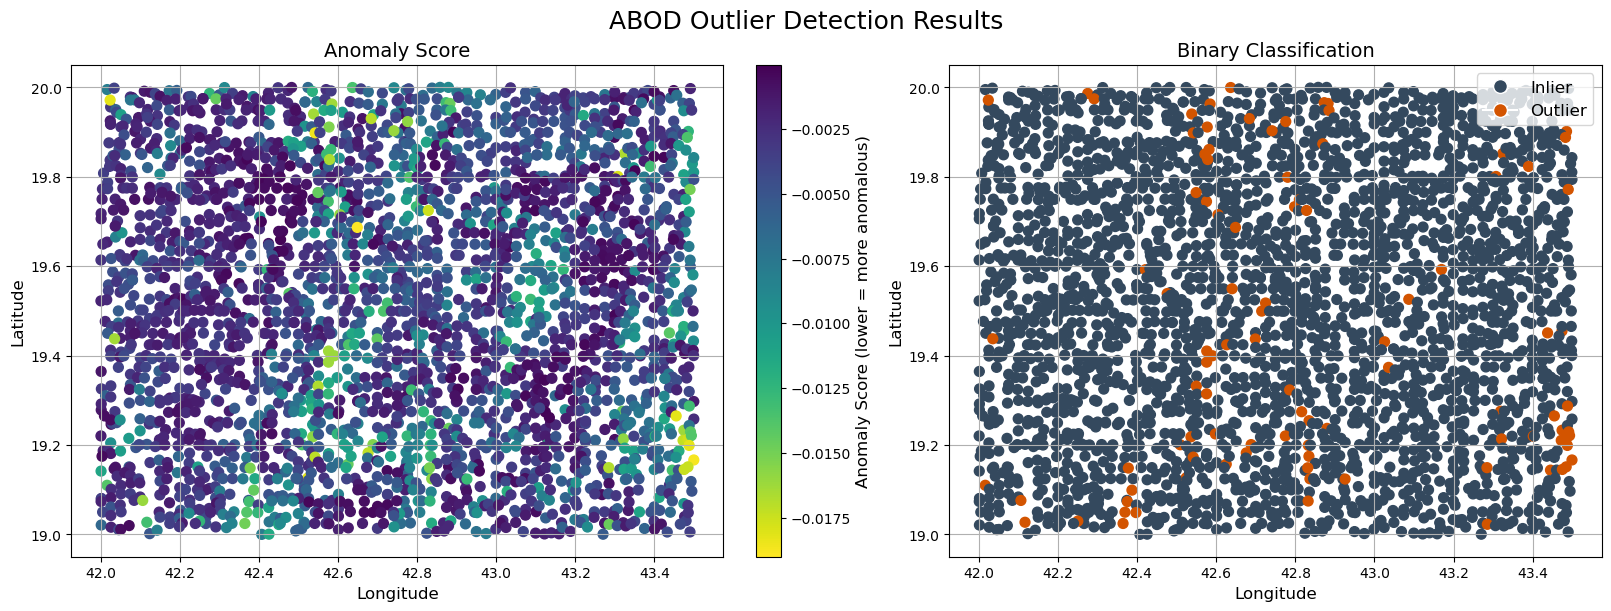

Classified 98 outliers out of 2728 samples


In [12]:
# Plotting ABOD results
helper_functions.plot_outlier_results(
    data=ABOD_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
    cmap="viridis_r",
)

---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [13]:
validation_df = pd.read_parquet('data_files/KSA_validation.parquet')

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

Points detected as outliers by 1 model: 251
Points detected as outliers by 2 models: 54
Points detected as outliers by all 3 models: 40


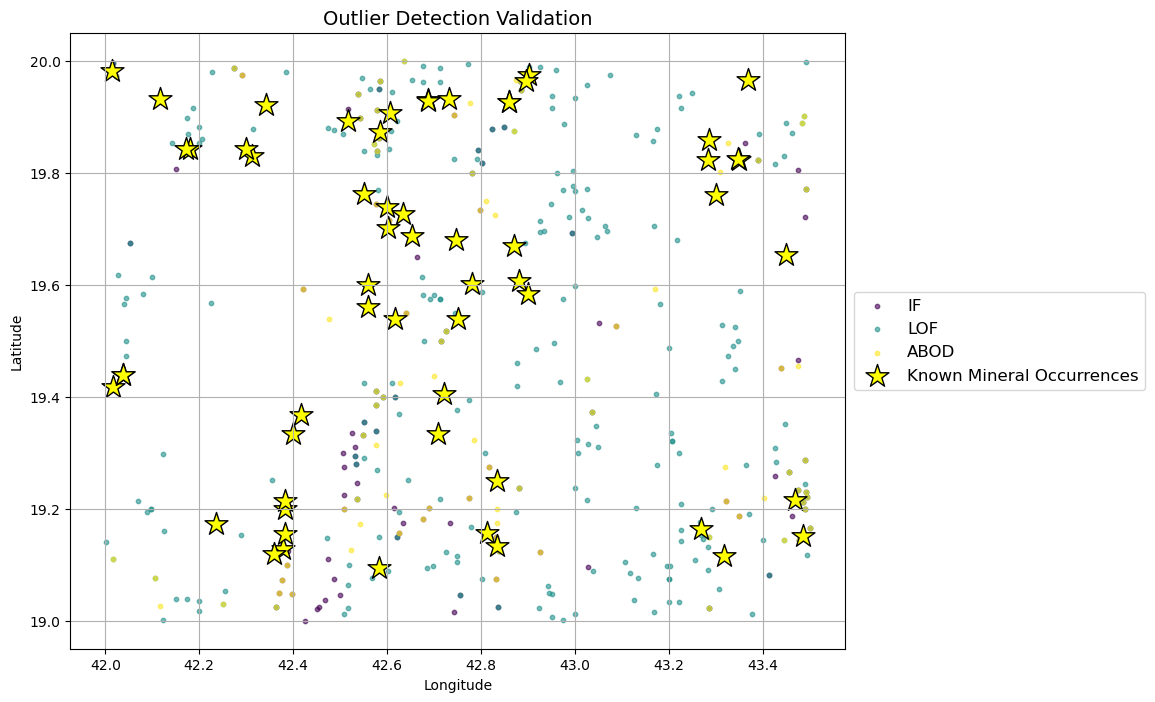

In [14]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ['IF', 'LOF', 'ABOD']

helper_functions.plot_validation(outlier_datasets=outlier_results, outlier_dataset_names=outlier_result_names, validation_df=validation_df, point_size=10, colormap='viridis')

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.

ROC-AUC Score for IF: 0.6980
ROC-AUC Score for LOF: 0.6475
ROC-AUC Score for ABOD: 0.7579
F-Score for IF: 30.6217
F-Score for LOF: 10.8421
F-Score for ABOD: 35.8927
Mutual Information Score for IF: 0.0031
Mutual Information Score for LOF: 0.0009
Mutual Information Score for ABOD: 0.0033


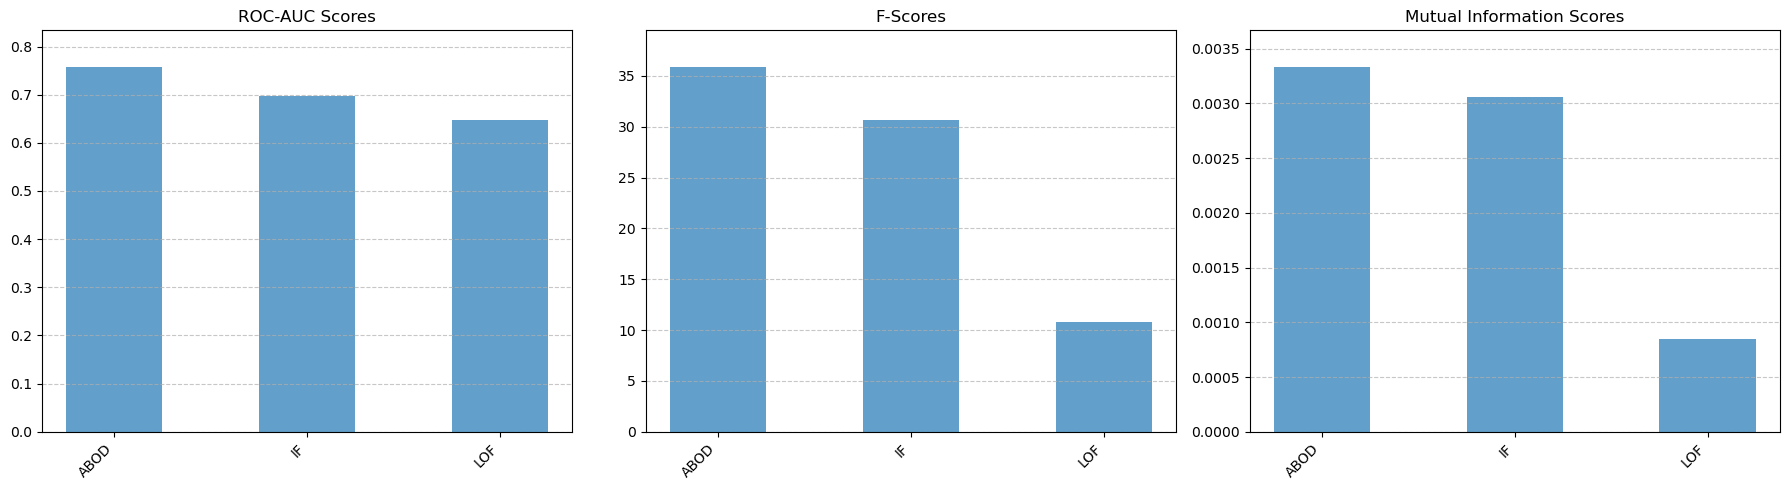

In [15]:
# Calculate scores for each outlier detection method

scoring_radius = 0.005 # roughly 500m

roc_auc_scores = helper_functions.calculate_roc_auc(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
) 

f_scores = helper_functions.calculate_f_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

mi_scores = helper_functions.calculate_mi_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

helper_functions.plot_scores(
    [roc_auc_scores, f_scores, mi_scores],
    titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"],
)

---

### *Deeper investigation into ROC-AUC scoring of each model*

Since the ROC-AUC scores for each model above are so similar, let's create a ROC curve to better understand the model performance. 

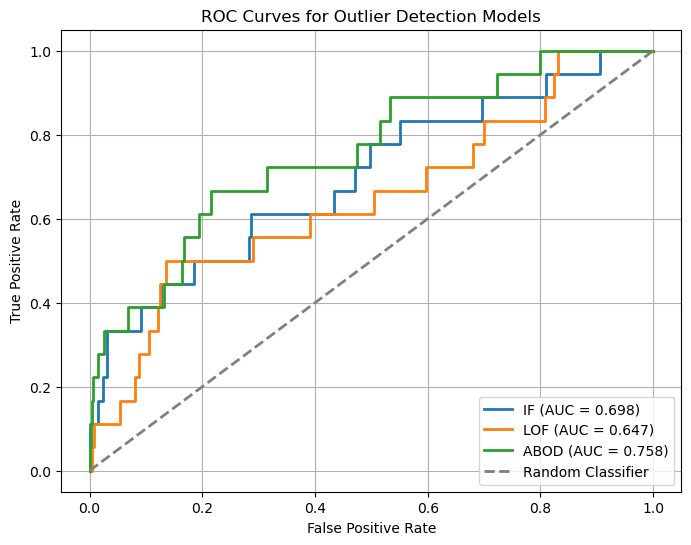

In [16]:
helper_functions.plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,  # Search radius
)

The ROC curve above matches the results we observed - the ABOD method appears to best optimize the TPR/FPR ratio, indicating better model performance. 

---

### <u>Time Cost Analysis</u>

Despite the quantitative accuracies between models, it is also important to consider the time cost of each; IF and LOF process almost instantly, while ABOD takes some time due to the nature of the calculation. This ABOD function is set up to allow for using k-nearest neighbors to calculate variance rather than using all possible pairs in the dataset, which improves processing time while potentially skewing results. For relatively small datasets, the time cost of ABOD is minimal, but for larger datasets the tradeoffs should be considered; it may be more efficient to use an algorithm like Isolation Forest despite the small cost in model accuracy. Further investigation into the effects of kNN on model accuracy is needed. 

Below we will do a brief investigation into the time cost of each method, focusing particularly on ABOD.

In [18]:
# Explore time cost of outlier detection vs. roc-auc score  --- using kNN for ABOD as processing time is too high for this many iterations

outlier_models = [
    outlier_detection_functions.isolation_forest,
    outlier_detection_functions.local_outlier_factor,
    lambda df, feature_columns: outlier_detection_functions.abod(
        df, feature_columns, use_knn=True, k_neighbors=50
    ),
]

outlier_model_names = ['IF', 'LOF', 'ABOD']
scoring_radius = 0.005

# Dictionary to store results
results = {
    "Model": [],
    "Iteration": [],
    "Execution Time (s)": [],
    "ROC-AUC Score": []
}

for model, name in zip(outlier_models, outlier_model_names):
    for i in range(7):
        start = time.time()
        output_df = model(df, feature_columns)
        end = time.time()
        exec_time = end - start

        print(f"{model.__name__} iteration {i} took {end - start} seconds")

        roc_auc_score = helper_functions.calculate_roc_auc(
            outlier_datasets=[output_df],
            outlier_dataset_names=[name],
            validation_df=validation_df,
            radius=scoring_radius,
        )[name]

        # Store results in dictionary
        results["Model"].append(name)
        results["Iteration"].append(i)
        results["Execution Time (s)"].append(exec_time)
        results["ROC-AUC Score"].append(roc_auc_score)

isolation_forest iteration 0 took 0.11397624015808105 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 1 took 0.10472631454467773 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 2 took 0.1037912368774414 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 3 took 0.10199928283691406 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 4 took 0.1022496223449707 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 5 took 0.1048729419708252 seconds
ROC-AUC Score for IF: 0.6980
isolation_forest iteration 6 took 0.10528707504272461 seconds
ROC-AUC Score for IF: 0.6980
local_outlier_factor iteration 0 took 0.06146860122680664 seconds
ROC-AUC Score for LOF: 0.6294
local_outlier_factor iteration 1 took 0.06466341018676758 seconds
ROC-AUC Score for LOF: 0.6294
local_outlier_factor iteration 2 took 0.06422305107116699 seconds
ROC-AUC Score for LOF: 0.6294
local_outlier_factor iteration 3 took 0.06273937225341797 seconds
ROC-AUC Scor

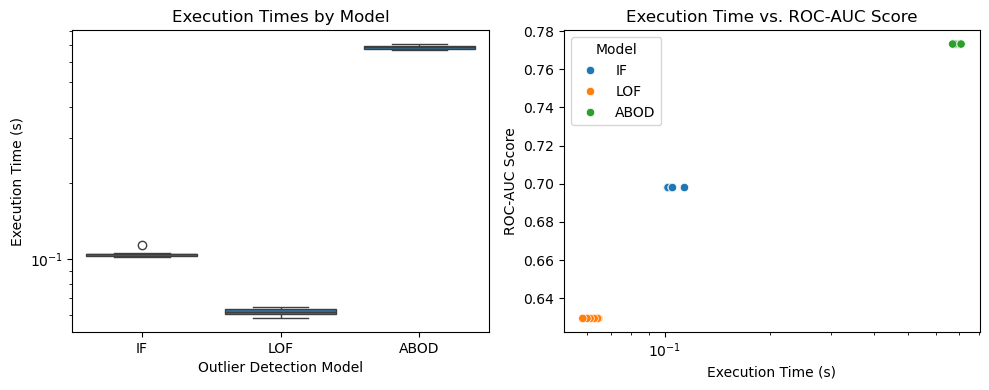

In [19]:
# Plot the results of the above analysis

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Box Plot
sns.boxplot(x="Model", y="Execution Time (s)", data=results_df, ax=axes[0])
axes[0].set_title("Execution Times by Model")
axes[0].set_xlabel("Outlier Detection Model")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_yscale("log")

# Scatter Plot
sns.scatterplot(
    x="Execution Time (s)", y="ROC-AUC Score", hue="Model", data=results_df, ax=axes[1]
)
axes[1].set_title("Execution Time vs. ROC-AUC Score")
axes[1].set_xlabel("Execution Time (s)")
axes[1].set_xscale("log")
axes[1].set_ylabel("ROC-AUC Score")
axes[1].legend(title="Model")

plt.tight_layout()
plt.show()

As we can see in the above plots, IF and LOF have significantly lower execution times. IF seems to strike somewhat of a balance between execution time and ROC-AUC score, indicating it may be more suitable than ABOD for datasets n > ~2000-3000 as the tradeoff between time and score diminishes. 

In [20]:
# Analyze the execution time of each method with varying sample sizes

# Define sample sizes
sample_sizes = [50, 100, 200, 400, 800, 1600, 2700]

# Measure execution time
abod_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.abod
)

if_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.isolation_forest
)

lof_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.local_outlier_factor
)



Processed 50 samples in 0.0144 seconds using abod
Processed 100 samples in 0.0226 seconds using abod
Processed 200 samples in 0.0737 seconds using abod
Processed 400 samples in 0.8370 seconds using abod
Processed 800 samples in 6.2810 seconds using abod
Processed 1600 samples in 49.9065 seconds using abod
Processed 2700 samples in 246.8928 seconds using abod
Processed 50 samples in 0.1230 seconds using isolation_forest
Processed 100 samples in 0.1026 seconds using isolation_forest
Processed 200 samples in 0.0958 seconds using isolation_forest
Processed 400 samples in 0.1074 seconds using isolation_forest
Processed 800 samples in 0.1022 seconds using isolation_forest
Processed 1600 samples in 0.1052 seconds using isolation_forest
Processed 2700 samples in 0.1123 seconds using isolation_forest
Processed 50 samples in 0.0130 seconds using local_outlier_factor
Processed 100 samples in 0.0145 seconds using local_outlier_factor
Processed 200 samples in 0.0146 seconds using local_outlier_fact

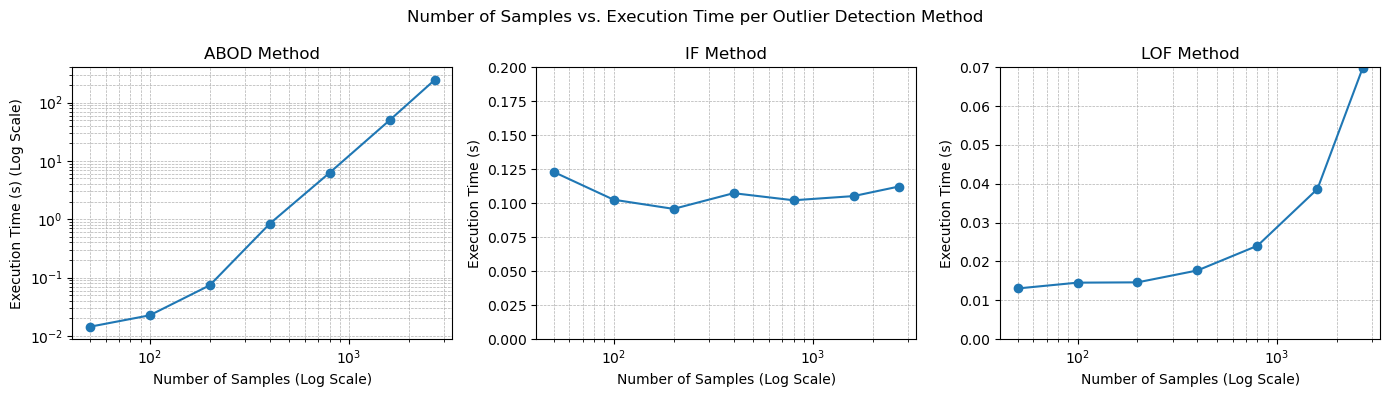

In [23]:
# Plot the above results
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# ABOD
axes[0].plot(
    abod_results_df["Number of Samples"],
    abod_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[0].set_xscale("log") 
axes[0].set_yscale("log")
axes[0].set_xlabel("Number of Samples (Log Scale)")
axes[0].set_ylabel("Execution Time (s) (Log Scale)")
axes[0].set_title("ABOD Method")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# IF
axes[1].plot(
    if_results_df["Number of Samples"],
    if_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[1].set_xlabel("Number of Samples (Log Scale)")
axes[1].set_xscale("log")  
axes[1].set_ylabel("Execution Time (s)")
axes[1].set_ylim(0, 0.2)
axes[1].set_title("IF Method")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

# LOF
axes[2].plot(
    lof_results_df["Number of Samples"],
    lof_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[2].set_xlabel("Number of Samples (Log Scale)")
axes[2].set_xscale("log")  
axes[2].set_ylabel("Execution Time (s)")
axes[2].set_ylim(0, 0.07)
axes[2].set_title("LOF Method")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)

fig.suptitle("Number of Samples vs. Execution Time per Outlier Detection Method")
plt.tight_layout()
plt.show()

As we can see above, ABOD has more similar execution times as IF/LOF (<1s) when n<~200, but beyond that the time cost grows exponentially. IF and LOF distributions are irregular due to the extremely short processing times, and variation can be attributed to random noise; they generally follow an O(n) time complexity, while ABOD appears to follow O(n^2), which aligns with the pairwise computations required to calculate ABOD. 

To summarize, ABOD seems to be the most appropriate model for smaller datasets (n<2000-3000), but beyond that the time cost becomes significant, and IF should be considered as a still plenty-capable alternative. 